In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
from keras import Sequential

Using TensorFlow backend.


In [5]:
from keras.layers import Dropout, Dense

In [6]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [7]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [8]:
from keras.optimizers import RMSprop, Adam

In [9]:
from keras.regularizers import l1_l2

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve

In [11]:
from numpy.random import seed
seed(8)
from tensorflow import set_random_seed
set_random_seed(8)

In [12]:
def morgan_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048)
    npfp = np.array(list(fp.ToBitString())).astype('int8')
    return npfp

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit
X = np.array([[1, 3], [3, 7], [2, 4], [4, 8]])
y = np.array([0, 1, 0, 1])

In [5]:
X

array([[1, 3],
       [3, 7],
       [2, 4],
       [4, 8]])

In [6]:
y

array([0, 1, 0, 1])

In [11]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=99)

In [12]:
sss.get_n_splits(X, y)

5

In [14]:
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [0 1] TEST: [3 2]
TRAIN: [3 0] TEST: [1 2]
TRAIN: [0 3] TEST: [2 1]
TRAIN: [2 1] TEST: [0 3]
TRAIN: [0 3] TEST: [2 1]


In [14]:
traindata = pd.read_csv('train_data.csv')
testdata = pd.read_csv('test_data.csv')
alldata = pd.read_csv('dataset.csv')

In [15]:
traindata.head()

,smiles_parents,LogKOH,Unnamed: 2
0,ClC(C(Cl)(Cl)Cl)Cl,7.000,halogeneted
1,N#CC#N,7.000,nitrile
2,C(Cl)(Br)C(F)(F)F,7.114,halogeneted
3,C(C)#N,7.342,nitrile
4,C(C)(=O)O,7.362,carboxyl


In [15]:
testdata.head()

,smiles_parents,LogKOH,Unnamed: 2
0,CC(C)(C)O,8.845,alcohol
1,CC(C)O,9.279,alcohol
2,C(C)O,9.322,alcohol
3,CC(C=O)C,9.462,aldehyde
4,C(CCC)=O,9.591,aldehyde


In [16]:
alldata.head()


,smiles_parents,LogKOH
0,CC,9.255
1,CCC,9.556
2,CCCC,9.663
3,CCCCC,9.732
4,CCCCCCC,9.886


In [16]:
traindata['fp'] = traindata["smiles_parents"].apply(morgan_fp)
testdata['fp'] = testdata["smiles_parents"].apply(morgan_fp)
alldata['fp'] = alldata["smiles_parents"].apply(morgan_fp)

In [17]:
traindata['fp'][0]

array([0, 1, 0, ..., 0, 0, 1], dtype=int8)

In [18]:
prop = 'LogKOH'

In [19]:
traindata = traindata[~traindata[prop].isnull()]
testdata = testdata[~testdata[prop].isnull()]
alldata = alldata[~alldata[prop].isnull()]

In [20]:
X_train = np.array(list(traindata['fp']))
X_test = np.array(list(testdata['fp']))
X_all_test = np.array(list(alldata['fp']))

In [21]:
print(np.shape(X_train))

(365, 2048)


In [22]:
print(np.shape(X_test))

(92, 2048)


In [23]:
Y_train = traindata[prop].values
Y_test = testdata[prop].values
Y_all_test = alldata[prop].values

In [24]:
Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)
Y_all_test = Y_all_test.reshape(-1, 1)

In [25]:
print(np.shape(Y_train))

(365, 1)


In [26]:
learn_rate = .0002

In [27]:
rgr_val1 = 0.0001
rgr_val2 = 0.016
weight_regular = l1_l2(rgr_val1, rgr_val2)

In [28]:
activation1 = "relu"
activation2 = "sigmoid"
activation3 = "tanh"

In [29]:
reduction_factor = 0.5
wait_time = 50
minimal_learn_rate = 0.00001
observed_metric = 'val_mean_squared_error'
reduce_lr = ReduceLROnPlateau(monitor=observed_metric, factor=reduction_factor, patience=wait_time,
                              min_lr=minimal_learn_rate, verbose=1)
earlyStopping = EarlyStopping(monitor=observed_metric, patience=50, verbose=0, mode='min')
mcp_save = ModelCheckpoint('mdl_wts.hdf5', save_best_only=True, monitor=observed_metric, mode='min')

In [30]:
from keras import optimizers
model = Sequential()
dropout1 = 0.2
dropout2=0.5

In [31]:
import sys
model.add(Dropout(0.0, input_shape=(X_test.shape[1],)))

model.add(Dense(output_dim=2048, activation=activation1, W_regularizer=weight_regular))
model.add(Dropout(dropout1))
model.add(Dense(output_dim=2048, activation=activation1, W_regularizer=weight_regular))
model.add(Dropout(dropout2))
model.add(Dense(output_dim=2048, activation=activation1, W_regularizer=weight_regular))
model.add(Dropout(dropout2))
model.add(Dense(Y_train.shape[1], activation='relu'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/jiajie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=2048, kernel_regularizer=<keras.reg...)`
  after removing the cwd from sys.path.
/home/jiajie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=2048, kernel_regularizer=<keras.reg...)`
  
/home/jiajie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=2048, kernel_regularizer=<keras.reg...)`
  


In [32]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [33]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
__________

In [34]:
num_of_epochs = 500
batch_size = 50

In [35]:
history = model.fit(X_train, Y_train, nb_epoch=num_of_epochs, batch_size=batch_size,
                    verbose=2, validation_data=(X_test, Y_test), callbacks=[reduce_lr,earlyStopping,mcp_save])

Instructions for updating:
Use tf.cast instead.


/home/jiajie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 365 samples, validate on 92 samples
Epoch 1/500
 - 3s - loss: 150.5377 - mean_squared_error: 39.8738 - val_loss: 122.3506 - val_mean_squared_error: 27.4556
Epoch 2/500
 - 2s - loss: 102.8244 - mean_squared_error: 16.2771 - val_loss: 84.8048 - val_mean_squared_error: 9.5554
Epoch 3/500
 - 2s - loss: 77.7115 - mean_squared_error: 8.5054 - val_loss: 70.6618 - val_mean_squared_error: 9.4453
Epoch 4/500
 - 2s - loss: 63.4101 - mean_squared_error: 6.1278 - val_loss: 54.4666 - val_mean_squared_error: 2.5623
Epoch 5/500
 - 1s - loss: 52.0502 - mean_squared_error: 2.9174 - val_loss: 47.2767 - val_mean_squared_error: 1.8292
Epoch 6/500
 - 2s - loss: 45.4548 - mean_squared_error: 2.0258 - val_loss: 44.3517 - val_mean_squared_error: 3.7457
Epoch 7/500
 - 2s - loss: 40.5760 - mean_squared_error: 1.5275 - val_loss: 38.7376 - val_mean_squared_error: 1.9608
Epoch 8/500
 - 2s - loss: 36.4484 - mean_squared_error: 1.0421 - val_loss: 35.4471 - val_mean_squared_error: 2.0319
Epoch 9/500
 - 2s - l

Epoch 72/500
 - 2s - loss: 1.9252 - mean_squared_error: 0.5449 - val_loss: 1.6267 - val_mean_squared_error: 0.2774
Epoch 73/500
 - 2s - loss: 1.7849 - mean_squared_error: 0.4557 - val_loss: 1.7041 - val_mean_squared_error: 0.4114
Epoch 74/500
 - 1s - loss: 1.8321 - mean_squared_error: 0.5525 - val_loss: 1.5448 - val_mean_squared_error: 0.2910
Epoch 75/500
 - 1s - loss: 1.7793 - mean_squared_error: 0.5460 - val_loss: 1.9943 - val_mean_squared_error: 0.7587
Epoch 76/500
 - 1s - loss: 1.9710 - mean_squared_error: 0.7633 - val_loss: 1.5968 - val_mean_squared_error: 0.4087
Epoch 77/500
 - 1s - loss: 1.7557 - mean_squared_error: 0.5598 - val_loss: 1.8881 - val_mean_squared_error: 0.7063
Epoch 78/500
 - 1s - loss: 1.8146 - mean_squared_error: 0.6243 - val_loss: 1.4602 - val_mean_squared_error: 0.2740
Epoch 79/500
 - 2s - loss: 1.7336 - mean_squared_error: 0.5507 - val_loss: 1.4518 - val_mean_squared_error: 0.2811
Epoch 80/500
 - 1s - loss: 1.6204 - mean_squared_error: 0.4666 - val_loss: 1.397

Epoch 143/500
 - 1s - loss: 0.6654 - mean_squared_error: 0.2467 - val_loss: 0.6140 - val_mean_squared_error: 0.1939
Epoch 144/500
 - 1s - loss: 0.6647 - mean_squared_error: 0.2463 - val_loss: 0.5879 - val_mean_squared_error: 0.1692
Epoch 145/500
 - 1s - loss: 0.6654 - mean_squared_error: 0.2488 - val_loss: 0.6106 - val_mean_squared_error: 0.2002
Epoch 146/500
 - 1s - loss: 0.6704 - mean_squared_error: 0.2573 - val_loss: 0.5820 - val_mean_squared_error: 0.1698
Epoch 147/500
 - 1s - loss: 0.6554 - mean_squared_error: 0.2421 - val_loss: 0.5955 - val_mean_squared_error: 0.1801
Epoch 148/500
 - 1s - loss: 0.6633 - mean_squared_error: 0.2508 - val_loss: 0.6038 - val_mean_squared_error: 0.1974
Epoch 149/500
 - 1s - loss: 0.6540 - mean_squared_error: 0.2455 - val_loss: 0.6024 - val_mean_squared_error: 0.1977
Epoch 150/500
 - 1s - loss: 0.6416 - mean_squared_error: 0.2351 - val_loss: 0.6106 - val_mean_squared_error: 0.2026
Epoch 151/500
 - 1s - loss: 0.6303 - mean_squared_error: 0.2267 - val_lo

In [36]:
model.load_weights('mdl_wts.hdf5')

In [37]:
y_test_pred = model.predict(X_test)

In [38]:
np.savetxt("y_test_pred.csv", y_test_pred, delimiter=",")

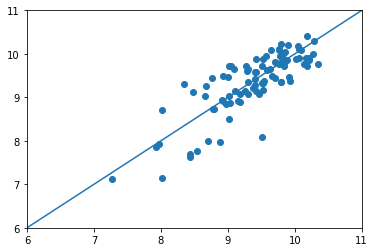

In [39]:
plt.scatter(y_test_pred,Y_test)
xx = np.arange(6,12)
yy =xx
plt.ylim(6,11)
plt.xlim(6,11)
plt.plot(xx,yy)

In [40]:
r = 1- np.sum((y_test_pred - Y_test)**2)/len(y_test_pred)

In [41]:
r

0.8312348442917332

In [42]:
MAE = np.sum(abs(y_test_pred - Y_test))/len(y_test_pred)
MAE

0.31176484729932685

In [43]:
MSE = np.sum((y_test_pred - Y_test)**2)/len(y_test_pred)
MSE

0.16876515570826675

In [44]:
RMSE = np.sqrt(MSE)
RMSE

0.4108103646553562

In [45]:
y_train_pred = model.predict(X_train)

In [46]:
np.savetxt("y_train_pred.csv", y_train_pred, delimiter=",")

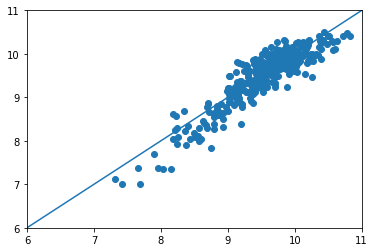

In [47]:
plt.scatter(y_train_pred,Y_train)
xx = np.arange(6,12)
yy =xx
plt.ylim(6,11)
plt.xlim(6,11)
plt.plot(xx,yy)

In [48]:
r = 1- np.sum((y_train_pred - Y_train)**2)/len(y_train_pred)

In [49]:
r

0.9278392629598036

In [50]:
MAE = np.sum(abs(y_train_pred - Y_train))/len(y_train_pred)
MAE

0.21093152018507869

In [51]:
MSE = np.sum((y_train_pred - Y_train)**2)/len(y_train_pred)
MSE

0.07216073704019649

In [52]:
RMSE = np.sqrt(MSE)
RMSE

0.26862750611245395

In [53]:
Y_all_pred = model.predict(X_all_test)

In [54]:
np.savetxt("y_all_pred.csv", Y_all_pred, delimiter=",")

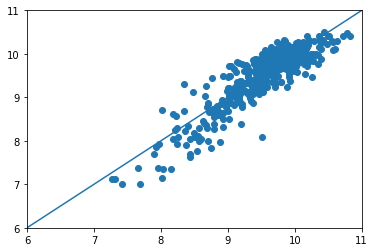

In [55]:
plt.scatter(Y_all_pred,Y_all_test)
xx = np.arange(6,12)
yy =xx
plt.ylim(6,11)
plt.xlim(6,11)
plt.plot(xx,yy)

In [56]:
r = 1- np.sum((Y_all_pred - Y_all_test)**2)/len(Y_all_pred)
r

0.9083915495941705

In [57]:
MAE = np.sum(abs(Y_all_pred - Y_all_test))/len(Y_all_pred)
MAE

0.2312305665464839

In [58]:
MSE = np.sum((Y_all_pred - Y_all_test)**2)/len(Y_all_pred)
MSE

0.09160845040582956

In [59]:
RMSE = np.sqrt(MSE)
RMSE

0.302668879149855